In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# pandasの表示行数と列数の設定
pd.options.display.max_rows = 400
pd.options.display.max_columns = None

# warningsを無視する
import warnings
warnings.filterwarnings("ignore")


# 1. データの読み込み

## 商品の売上

In [ ]:
# store: 店舗番号
# dept: 商品部門番号
# week: 各週の月曜日の日付
# sales: 売上金額
df_sales = pd.read_csv('data/sales.csv', parse_dates=['week'])
df_sales.head(2)

,store,dept,week,sales
0,1,1,2010-02-01,24924.50
1,1,1,2010-02-08,46039.49


# 2. 時系列の可視化

## 簡単な時系列グラフ、時間データの初期観察用

### 売上データ、1号店の1号部門を例に

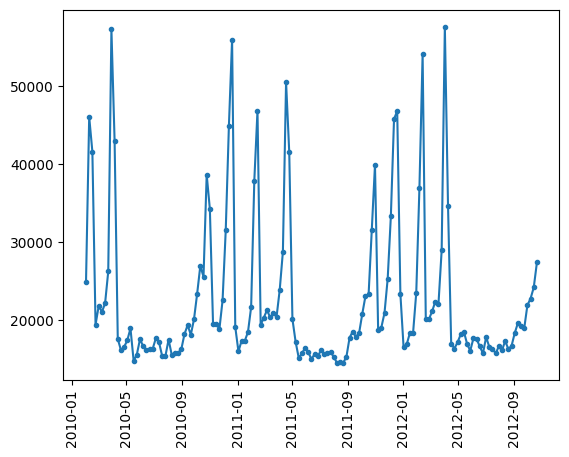

In [ ]:
# 全時系列グラフ
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')
plt.plot( df['week'], df['sales'],'.-' )
plt.xticks(rotation=90)
plt.show()

結論: 1号店1号部門の売上は1年（52週）単位の周期性を示す

## 季節性時系列グラフ

### データ準備

In [ ]:
# 1号店1号部門の売上データを例に
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')

#各週がどの年に属するかを計算
df['year'] = df['week'].dt.year

#各週がその年の第何週かを計算
df['week_of_year'] = df['week'].dt.isocalendar().week

### グラフ作成

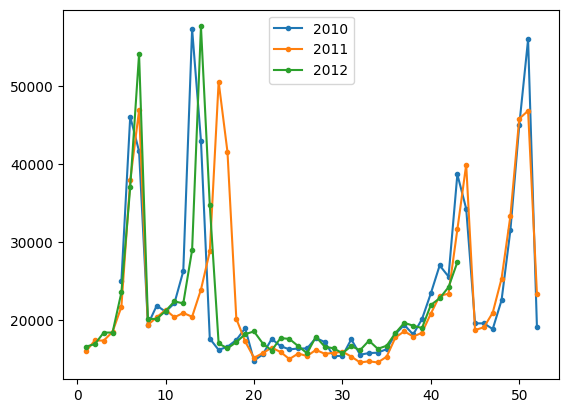

In [39]:
for year in df['year'].unique():
    tmp_df = df[ df['year']==year ]
    plt.plot( tmp_df['week_of_year'], tmp_df['sales'],'.-', label=str(year) )
plt.legend()
plt.show()

結論： 
1. 毎年19週-43週（4-10月）は売上が低い
2. 毎年44週-翌年18週（10-4月）はプロモーション活動がある可能性
3. トレンドとしては11年が10年と12年よりやや低い

## 季節性箱ひげ図

### データ準備

In [ ]:
# 1号店1号部門の売上データを例に
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')

#各週がその年の第何週かを計算
df['week_of_year'] = df['week'].dt.isocalendar().week

#同じ週のデータをリストにまとめる
df_boxplot = df.groupby(['week_of_year'])['sales'].agg(list).reset_index()

### グラフ作成

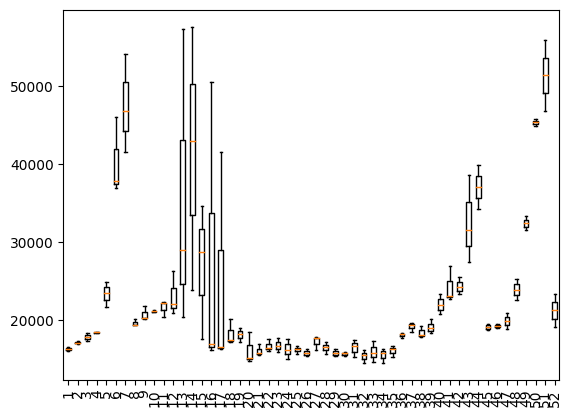

In [41]:
plt.boxplot( df_boxplot['sales'].values, labels=df_boxplot['week_of_year'].values )
plt.xticks(rotation=90)
plt.show()

## トレンド箱ひげ図

### データ準備

In [ ]:
# 1号店1号部門の売上データを例に
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')

#各週がどの年に属するかを計算
df['year'] = df['week'].dt.year

#各週がその年の第何週かを計算
df['week_of_year'] = df['week'].dt.isocalendar().week

#プロモーション活動の影響を受ける週を除外
df = df[ (df['week_of_year']>=19) & 
       (df['week_of_year']<=43)]

#同じ年のデータをリストにまとめる
df_boxplot = df.groupby(['year'])['sales'].agg(list).reset_index()

### グラフ作成

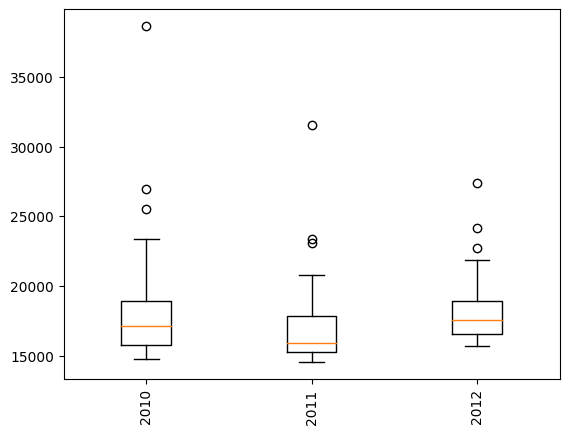

In [43]:
plt.boxplot( df_boxplot['sales'].values, labels=df_boxplot['year'].values )
plt.xticks(rotation=90)
plt.show()

# 周期性の判断方法

ACF検定 (Auto-Correlation Function, 自己相関関数検定） 
$$ r_h = Cor( X_t, X_{t+h} ) , \forall t$$
h単位ごとにACF値に局所的なピークがある場合、データはh単位の周期性を持つ

## データ準備

In [ ]:
# 1号店1号部門の売上データを例に
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')

## 周期性の計算

In [45]:
from  statsmodels.graphics.tsaplots import plot_acf

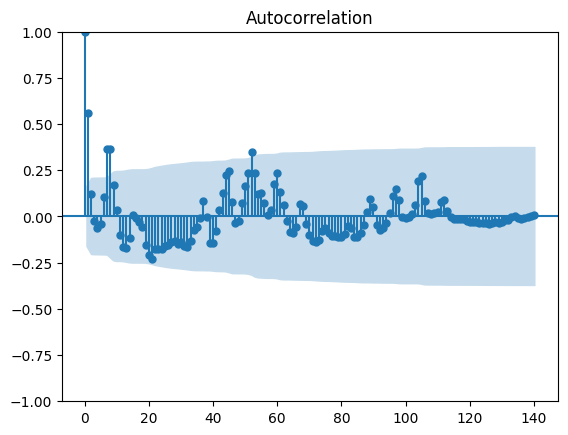

In [46]:
plot_acf(df['sales'], lags=140).show()

結論：データは52週（1年）単位の周期性を持つ

# 3. STLアルゴリズムで時系列を分解

## データ準備

In [ ]:
# 1号店1号部門の売上データを例に
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')

## STL分解

In [48]:
from statsmodels.tsa.seasonal import STL

In [ ]:
stl = STL(df['sales'].values, period=52) #period: 時系列の周期
res = stl.fit()

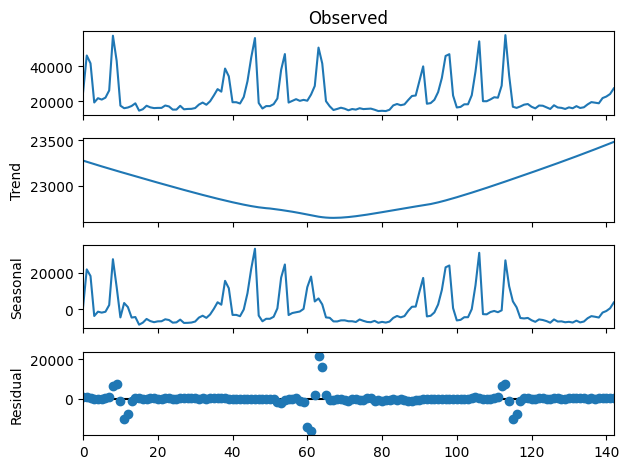

In [ ]:
## 分解結果の可視化
fig = res.plot()

In [ ]:
## 結果の数値を取得
df['trend'] = res.trend
df['seasonal'] = res.seasonal
df['residule'] = res.resid

In [52]:
df

,store,dept,week,sales,trend,seasonal,residule
0,1,1,2010-02-01,24924.50,23277.726484,1009.587224,637.186292
1,1,1,2010-02-08,46039.49,23264.875227,21817.972147,956.642626
2,1,1,2010-02-15,41595.55,23252.134232,18180.173545,163.242223
3,1,1,2010-02-22,19403.54,23239.503284,-3822.738460,-13.224824
4,1,1,2010-03-01,21827.90,23226.981632,-1455.928194,56.846562
5,1,1,2010-03-08,21043.39,23214.568454,-1976.582305,-194.596149
6,1,1,2010-03-15,22136.64,23202.262889,-1498.156304,432.533415
7,1,1,2010-03-22,26229.21,23190.064138,2199.918411,839.227451
8,1,1,2010-03-29,57258.43,23177.970635,27435.396454,6645.062911
9,1,1,2010-04-05,42960.91,23165.977629,12047.770473,7747.161898
